# ETH Data Preprocessing

This notebook demonstrates the process of loading and preprocessing Ethereum (ETH) daily price data from a CSV file. The primary goal is to prepare the data for further analysis or machine learning tasks.

# Table of Contents
- [Import Library](#import-library)
- [Load and Process Data Function](#load-and-process-data-function)

## Import Library

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import os

## Load and Process Data Function

> The `load_and_process_data` function reads Ethereum (ETH) daily price data from a given CSV file, renames and formats columns, sorts the data chronologically, drops unnecessary columns, and saves the processed data to a new CSV file named 'ohlcv_daily.csv', while returning the resulting Pandas DataFrame.

In [62]:
def load_and_process_data(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path, header=1)

    # Rename columns
    df.rename(columns={'date': 'trading_point', 'Volume USD': 'volume'}, inplace=True)

    # Convert 'trading_point' to datetime and remove timestamp
    df['trading_point'] = pd.to_datetime(df['trading_point']).dt.strftime('%Y-%m-%d')

    # Sort the DataFrame by 'trading_point'
    df.sort_values(by='trading_point', inplace=True)

    # Drop unnecessary columns
    df.drop(columns=['unix', 'symbol', 'Volume ETH'], inplace=True)

    return df

In [63]:
eth_daily = load_and_process_data('./data/Bitstamp_ETHUSD_d.csv')
eth_hour = load_and_process_data('./data/Bitstamp_ETHUSD_1h.csv')
wiki_df = pd.read_csv('./data/ethereum_wikipedia.csv', index_col=0, parse_dates=True)

## EDA

In [64]:
eth_daily.set_index('trading_point', inplace=True)
eth_hour.set_index('trading_point', inplace=True)

In [65]:
eth_daily.index = pd.to_datetime(eth_daily.index)
eth_hour.index = pd.to_datetime(eth_hour.index)

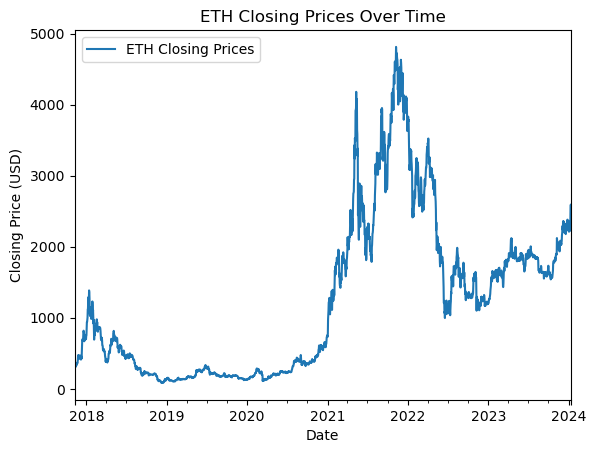

In [66]:
eth_daily.plot.line(y='close', use_index=True, style='-', label='ETH Closing Prices')
plt.title('ETH Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)');

In [67]:
# Merging based on date
eth_daily = eth_daily.merge(wiki_df, left_index=True, right_index=True)
eth_hour = eth_hour.merge(wiki_df, left_index=True, right_index=True)

In [68]:
eth_daily['tomorrow'] = eth_daily['close'].shift(-1)
eth_hour['next_hour'] = eth_hour['close'].shift(-1)

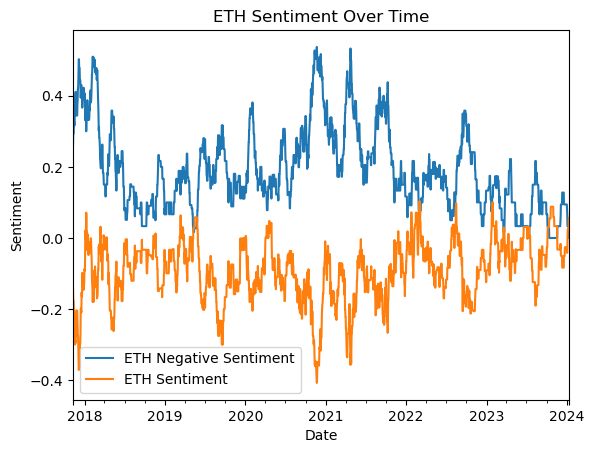

In [69]:
eth_daily['negative_sentiment'].plot.line(use_index=True, style='-', label='ETH Negative Sentiment')
eth_daily['sentiment'].plot.line(use_index=True, style='-', label='ETH Sentiment')

plt.title('ETH Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'sentiment_and_negative_sentiment.png'));

> This chart is showing that the positive sentiment for ETH in the early days was low while the negative sentiment was high but as time goes on the emotional sentiment towards ETH is shifting for the positive as the technology matures.

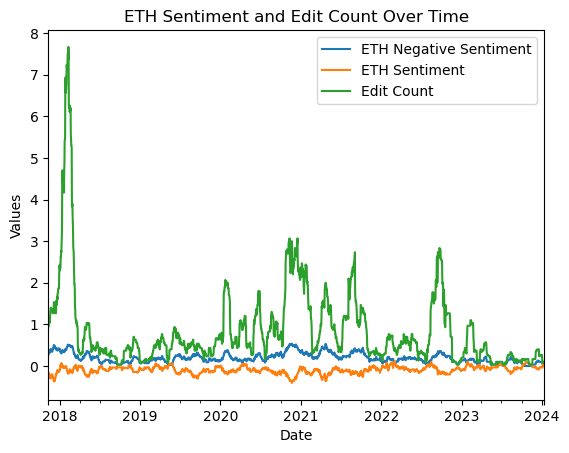

In [70]:
eth_daily['negative_sentiment'].plot.line(use_index=True, style='-', label='ETH Negative Sentiment')
eth_daily['sentiment'].plot.line(use_index=True, style='-', label='ETH Sentiment')
eth_daily['edit_count'].plot.line(use_index=True, style='-', label='Edit Count')

plt.title('ETH Sentiment and Edit Count Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'sentiment_and_edit_count.png'));

> Less edits are being made per day as the sentiment grows positive over time.

In [71]:
eth_daily['target'] = (eth_daily['tomorrow'] > eth_daily['close']).astype(int)
eth_daily['target'].value_counts()

1    1147
0    1108
Name: target, dtype: int64

In [72]:
eth_hour['target'] = (eth_hour['next_hour'] > eth_hour['close']).astype(int)
eth_hour['target'].value_counts()

0    25002
1    24601
Name: target, dtype: int64

In [73]:
def rolling_averages_daily(eth):
    horizons = [2,7,60,365]
    new_predictors = ['close', 'sentiment', 'negative_sentiment']
    
    for horizon in horizons:
        roll_averages = eth.rolling(horizon, min_periods=1).mean()
        
        ratio_column = f"close_ratio_{horizon}"
        eth[ratio_column] = eth['close'] / roll_averages['close']
        
        edit_column = f"edit_{horizon}"
        eth[edit_column] = roll_averages['edit_count']
        
        rolling = eth.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        eth[trend_column] = rolling['target']
        
        new_predictors += [ratio_column, trend_column, edit_column]
        
    return eth, new_predictors

In [74]:
def rolling_averages_hour(eth):
    horizons = [1,2,6,12]
    new_predictors = ['close', 'sentiment', 'negative_sentiment']
    
    for horizon in horizons:
        roll_averages = eth.rolling(horizon, min_periods=1).mean()
        
        ratio_column = f"close_ratio_{horizon}"
        eth[ratio_column] = eth['close'] / roll_averages['close']
        
        edit_column = f"edit_{horizon}"
        eth[edit_column] = roll_averages['edit_count']
        
        rolling = eth.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        eth[trend_column] = rolling['target']
        
        new_predictors += [ratio_column, trend_column, edit_column]
        
    return eth, new_predictors

In [75]:
eth_daily, new_predictors = rolling_averages_daily(eth_daily.copy())
eth_hour, new_predictors = rolling_averages_hour(eth_hour.copy())

In [76]:
eth_daily.to_csv('./data/ohlcv_daily.csv', index=False)
eth_hour.to_csv('./data/ohlcv_hour.csv', index=False)